# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('movielens_5_injected_H10000.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

105000

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 874724710, 'u': 'bottom_255', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 10000, 'bip': True, 'cost': 0.0}
{'t': 874724727, 'u': 'bottom_286', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 10000, 'bip': True, 'cost': 0.0}
{'t': 874724754, 'u': 'bottom_298', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 10000, 'bip': True, 'cost': 0.0}
{'t': 874724781, 'u': 'bottom_185', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 10000, 'bip': True, 'cost': 0.0}
{'t': 874724843, 'u': 'bottom_173', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 10000, 'bip': True, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 874724710,
 'u': 'bottom_255',
 'v': 'top_259',
 'is_fraud': 0,
 'history_type': 'H',
 'history_size': 10000,
 'bip': True,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,64.0,18.0,1.0,1.0,0.0,102.0,64.0,18.0,1.0,1.0,0.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104996,893286638,bottom_328,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,40.0,19.0,2.0,1.0,8.0,102.0,40.0,19.0,2.0,1.0,8.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104997,893286638,bottom_333,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,33.0,20.0,5.0,4.0,19.0,99.0,33.0,20.0,5.0,4.0,19.0,99.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104998,893286638,bottom_689,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,64.0,18.0,1.0,1.0,0.0,102.0,64.0,18.0,1.0,1.0,0.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104996,893286638,bottom_328,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,40.0,19.0,2.0,1.0,8.0,102.0,40.0,19.0,2.0,1.0,8.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104997,893286638,bottom_333,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,33.0,20.0,5.0,4.0,19.0,99.0,33.0,20.0,5.0,4.0,19.0,99.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104998,893286638,bottom_689,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.050000e+05,105000.000000,105000.0,1.050000e+05,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.0,95000.000000,95000.0,95000.000000,95000.000000,95000.000000
mean,8.835258e+08,0.047619,10000.0,1.488095e-07,1317.572053,278.941032,178.265147,1.0,63.990053,4.287326,278.853642,178.304221,1.0,63.990053,4.287326,466.697884,243.973274,68.923947,1.0,440.452747,1.289537,243.888958,68.880084,1.0,440.454853,1.289537,17.271905,86.445979,44.392284,11.291905,284.655189,63.780389,17.278863,86.466568,44.379000,11.286284,284.645895,63.785074,9996.966463,10000.0,9993.932926,3.033537,1.0,1.955579,1.0,1.000726,9986.678389,3.030663
std,5.345223e+06,0.212960,0.0,4.821980e-05,53.008131,19.698152,20.400824,0.0,6.433666,0.452517,19.686582,20.331307,0.0,6.433666,0.452517,18.594238,15.773290,7.544198,0.0,122.840369,0.453550,15.681540,7.599727,0.0,122.839918,0.453550,12.930885,92.120318,58.304848,42.982837,266.063626,50.445228,12.936227,92.134379,58.290483,42.954819,266.060515,50.452777,1.715840,0.0,3.431680,1.715840,0.0,0.206030,0.0,0.026941,269.157848,1.716921
min,8.747247e+08,0.000000,10000.0,0.000000e+00,1239.000000,225.000000,122.000000,1.0,48.000000,4.000000,225.000000,122.000000,1.0,48.000000,4.000000,414.000000,207.000000,49.000000,1.0,241.000000,1.000000,207.000000,48.000000,1.0,241.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9992.000000,10000.0,9984.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,8.794484e+08,0.000000,10000.0,0.000000e+00,1268.000000,264.000000,163.000000,1.0,61.000000,4.000000,264.000000,163.000000,1.0,61.000000,4.000000,453.000000,232.000000,64.000000,1.0,339.000000,1.000000,232.000000,64.000000,1.0,339.000000,1.000000,7.000000,20.000000,9.000000,1.000000,71.000000,24.000000,7.000000,20.000000,9.000000,1.000000,71.000000,24.000000,9996.000000,10000.0,9992.000000,2.000000,1.0,2.000000,1.0,1.000000,9992.000000,2.000000
50%,8.828265e+08,0.000000,10000.0,0.000000e+00,1313.000000,279.000000,178.000000,1.0,64.000000,4.000000,278.000000,178.000000,1.0,64.000000,4.000000,465.000000,242.000000,69.000000,1.0,414.000000,1.000000,242.000000,69.000000,1.0,415.000000,1.000000,14.000000,55.000000,22.000000,2.000000,200.000000,51.000000,14.000000,55.000000,22.000000,2.000000,200.000000,51.000000,9997.000000,10000.0,9994.000000,3.000000,1.0,2.000000,1.0,1.000000,9994.000000,3.000000
75%,8.882664e+08,0.000000,10000.0,0.000000e+00,1358.000000,294.000000,194.000000,1.0,67.000000,5.000000,294.000000,194.000000,1.0,67.000000,5.000000,480.000000,258.000000,74.000000,1.0,484.000000,2.000000,258.000000,74.000000,1.0,484.000000,2.000000,24.00

# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
10000,876185855,bottom_275,top_711,0,H,10000,True,0.0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,27.0,16.0,6.0,1.0,60.0,94.0,27.0,16.0,6.0,1.0,60.0,94.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10001,876185896,bottom_222,top_711,0,H,10000,True,0.0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,37.0,17.0,3.0,2.0,18.0,93.0,37.0,17.0,3.0,2.0,18.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10002,876185896,bottom_744,top_711,0,H,10000,True,0.0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,2.0,18.0,152.0,1.0,840.0,93.0,2.0,18.0,152.0,1.0,840.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10003,876185920,bottom_151,top_711,0,H,10000,True,0.0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,38.0,19.0,3.0,1.0,16.0,92.0,38.0,19.0,3.0,1.0,16.0,92.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10004,876185920,bottom_25,top_711,0,H,10000,True,0.0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,33.0,20.0,4.0,2.0,31.0,91.0,33.0,20.0,4.0,2.0,31.0,91.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,64.0,18.0,1.0,1.0,0.0,102.0,64.0,18.0,1.0,1.0,0.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104996,893286638,bottom_328,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,40.0,19.0,2.0,1.0,8.0,102.0,40.0,19.0,2.0,1.0,8.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104997,893286638,bottom_333,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,33.0,20.0,5.0,4.0,19.0,99.0,33.0,20.0,5.0,4.0,19.0,99.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104998,893286638,bottom_689,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,876185788,bottom_283,top_711,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,876185812,bottom_1115,top_711,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,876185812,bottom_676,top_711,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,876185832,bottom_476,top_711,0,H,10000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,9.500000e+04,95000.000000,95000.0,9.500000e+04,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.0,95000.000000,95000.0,95000.000000,95000.000000,95000.000000
mean,8.843846e+08,0.047421,10000.0,1.644737e-07,1317.572053,278.941032,178.265147,1.0,63.990053,4.287326,278.853642,178.304221,1.0,63.990053,4.287326,466.697884,243.973274,68.923947,1.0,440.452747,1.289537,243.888958,68.880084,1.0,440.454853,1.289537,17.271905,86.445979,44.392284,11.291905,284.655189,63.780389,17.278863,86.466568,44.379000,11.286284,284.645895,63.785074,9996.966463,10000.0,9993.932926,3.033537,1.0,1.955579,1.0,1.000726,9986.678389,3.030663
std,4.880283e+06,0.212539,0.0,5.069419e-05,53.008131,19.698152,20.400824,0.0,6.433666,0.452517,19.686582,20.331307,0.0,6.433666,0.452517,18.594238,15.773290,7.544198,0.0,122.840369,0.453550,15.681540,7.599727,0.0,122.839918,0.453550,12.930885,92.120318,58.304848,42.982837,266.063626,50.445228,12.936227,92.134379,58.290483,42.954819,266.060515,50.452777,1.715840,0.0,3.431680,1.715840,0.0,0.206030,0.0,0.026941,269.157848,1.716921
min,8.761859e+08,0.000000,10000.0,0.000000e+00,1239.000000,225.000000,122.000000,1.0,48.000000,4.000000,225.000000,122.000000,1.0,48.000000,4.000000,414.000000,207.000000,49.000000,1.0,241.000000,1.000000,207.000000,48.000000,1.0,241.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9992.000000,10000.0,9984.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,8.799004e+08,0.000000,10000.0,0.000000e+00,1268.000000,264.000000,163.000000,1.0,61.000000,4.000000,264.000000,163.000000,1.0,61.000000,4.000000,453.000000,232.000000,64.000000,1.0,339.000000,1.000000,232.000000,64.000000,1.0,339.000000,1.000000,7.000000,20.000000,9.000000,1.000000,71.000000,24.000000,7.000000,20.000000,9.000000,1.000000,71.000000,24.000000,9996.000000,10000.0,9992.000000,2.000000,1.0,2.000000,1.0,1.000000,9992.000000,2.000000
50%,8.839479e+08,0.000000,10000.0,0.000000e+00,1313.000000,279.000000,178.000000,1.0,64.000000,4.000000,278.000000,178.000000,1.0,64.000000,4.000000,465.000000,242.000000,69.000000,1.0,414.000000,1.000000,242.000000,69.000000,1.0,415.000000,1.000000,14.000000,55.000000,22.000000,2.000000,200.000000,51.000000,14.000000,55.000000,22.000000,2.000000,200.000000,51.000000,9997.000000,10000.0,9994.000000,3.000000,1.0,2.000000,1.0,1.000000,9994.000000,3.000000
75%,8.886370e+08,0.000000,10000.0,0.000000e+00,1358.000000,294.000000,194.000000,1.0,67.000000,5.000000,294.000000,194.000000,1.0,67.000000,5.000000,480.000000,258.000000,74.000000,1.0,484.000000,2.000000,258.000000,74.000000,1.0,484.000000,2.000000,24.0000

In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
10000,0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,27.0,16.0,6.0,1.0,60.0,94.0,27.0,16.0,6.0,1.0,60.0,94.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10001,0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,37.0,17.0,3.0,2.0,18.0,93.0,37.0,17.0,3.0,2.0,18.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10002,0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,2.0,18.0,152.0,1.0,840.0,93.0,2.0,18.0,152.0,1.0,840.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10003,0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,38.0,19.0,3.0,1.0,16.0,92.0,38.0,19.0,3.0,1.0,16.0,92.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10004,0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,33.0,20.0,4.0,2.0,31.0,91.0,33.0,20.0,4.0,2.0,31.0,91.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,64.0,18.0,1.0,1.0,0.0,102.0,64.0,18.0,1.0,1.0,0.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104996,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,40.0,19.0,2.0,1.0,8.0,102.0,40.0,19.0,2.0,1.0,8.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104997,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,33.0,20.0,5.0,4.0,19.0,99.0,33.0,20.0,5.0,4.0,19.0,99.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104998,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


In [18]:
df_features.describe()

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.000000,95000.0,95000.000000,95000.000000,95000.0,95000.000000,95000.0,95000.000000,95000.000000,95000.000000
mean,0.047421,1317.572053,278.941032,178.265147,1.0,63.990053,4.287326,278.853642,178.304221,1.0,63.990053,4.287326,466.697884,243.973274,68.923947,1.0,440.452747,1.289537,243.888958,68.880084,1.0,440.454853,1.289537,17.271905,86.445979,44.392284,11.291905,284.655189,63.780389,17.278863,86.466568,44.379000,11.286284,284.645895,63.785074,9996.966463,10000.0,9993.932926,3.033537,1.0,1.955579,1.0,1.000726,9986.678389,3.030663
std,0.212539,53.008131,19.698152,20.400824,0.0,6.433666,0.452517,19.686582,20.331307,0.0,6.433666,0.452517,18.594238,15.773290,7.544198,0.0,122.840369,0.453550,15.681540,7.599727,0.0,122.839918,0.453550,12.930885,92.120318,58.304848,42.982837,266.063626,50.445228,12.936227,92.134379,58.290483,42.954819,266.060515,50.452777,1.715840,0.0,3.431680,1.715840,0.0,0.206030,0.0,0.026941,269.157848,1.716921
min,0.000000,1239.000000,225.000000,122.000000,1.0,48.000000,4.000000,225.000000,122.000000,1.0,48.000000,4.000000,414.000000,207.000000,49.000000,1.0,241.000000,1.000000,207.000000,48.000000,1.0,241.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9992.000000,10000.0,9984.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,0.000000,1268.000000,264.000000,163.000000,1.0,61.000000,4.000000,264.000000,163.000000,1.0,61.000000,4.000000,453.000000,232.000000,64.000000,1.0,339.000000,1.000000,232.000000,64.000000,1.0,339.000000,1.000000,7.000000,20.000000,9.000000,1.000000,71.000000,24.000000,7.000000,20.000000,9.000000,1.000000,71.000000,24.000000,9996.000000,10000.0,9992.000000,2.000000,1.0,2.000000,1.0,1.000000,9992.000000,2.000000
50%,0.000000,1313.000000,279.000000,178.000000,1.0,64.000000,4.000000,278.000000,178.000000,1.0,64.000000,4.000000,465.000000,242.000000,69.000000,1.0,414.000000,1.000000,242.000000,69.000000,1.0,415.000000,1.000000,14.000000,55.000000,22.000000,2.000000,200.000000,51.000000,14.000000,55.000000,22.000000,2.000000,200.000000,51.000000,9997.000000,10000.0,9994.000000,3.000000,1.0,2.000000,1.0,1.000000,9994.000000,3.000000
75%,0.000000,1358.000000,294.000000,194.000000,1.0,67.000000,5.000000,294.000000,194.000000,1.0,67.000000,5.000000,480.000000,258.000000,74.000000,1.0,484.000000,2.000000,258.000000,74.000000,1.0,484.000000,2.000000,24.000000,123.000000,54.000000,3.000000,430.000000,98.000000,24.000000,123.000000,54.000000,3.000000,430.000000,98.000000,9998.000000,10000.0,9996.000000,4.000000,1.0,2.000000,1.0,1.000000,9996.000000,4.000000
max,1.000000,1450.000000,328.000000,237.000000,1.0,84.00000

In [19]:
df_target = df["is_fraud"]
df_target

10000     0
10001     0
10002     0
10003     0
10004     0
         ..
104995    0
104996    0
104997    0
104998    0
104999    0
Name: is_fraud, Length: 95000, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
10000,0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,27.0,16.0,6.0,1.0,60.0,94.0,27.0,16.0,6.0,1.0,60.0,94.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10001,0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,37.0,17.0,3.0,2.0,18.0,93.0,37.0,17.0,3.0,2.0,18.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10002,0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,2.0,18.0,152.0,1.0,840.0,93.0,2.0,18.0,152.0,1.0,840.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10003,0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,38.0,19.0,3.0,1.0,16.0,92.0,38.0,19.0,3.0,1.0,16.0,92.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
10004,0,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,33.0,20.0,4.0,2.0,31.0,91.0,33.0,20.0,4.0,2.0,31.0,91.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76495,0,1378.0,271.0,202.0,1.0,61.0,4.0,271.0,202.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,22.0,76.0,14.0,1.0,79.0,39.0,22.0,76.0,14.0,1.0,79.0,39.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76496,0,1378.0,271.0,202.0,1.0,61.0,4.0,271.0,202.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,34.0,77.0,1.0,1.0,14.0,39.0,34.0,77.0,1.0,1.0,14.0,39.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76497,0,1378.0,271.0,202.0,1.0,61.0,4.0,271.0,202.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,25.0,78.0,11.0,3.0,51.0,37.0,25.0,78.0,11.0,3.0,51.0,37.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76498,0,1378.0,271.0,202.0,1.0,61.0,4.0,271.0,202.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,10.0,79.0,40.0,2.0,319.0,36.0,10.0,79.0,40.0,2.0,319.0,36.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0


In [23]:
test_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
76500,0,1378.0,271.0,201.0,1.0,61.0,4.0,271.0,201.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,4.0,81.0,84.0,1.0,687.0,36.0,4.0,81.0,85.0,1.0,687.0,36.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76501,0,1378.0,272.0,200.0,1.0,61.0,4.0,272.0,200.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,24.0,82.0,5.0,2.0,62.0,35.0,24.0,82.0,5.0,2.0,62.0,35.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76502,0,1378.0,273.0,198.0,1.0,61.0,4.0,273.0,198.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,3.0,83.0,136.0,1.0,771.0,35.0,3.0,83.0,135.0,1.0,772.0,35.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76503,0,1377.0,272.0,198.0,1.0,61.0,4.0,272.0,198.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,19.0,84.0,16.0,2.0,112.0,34.0,19.0,84.0,16.0,2.0,112.0,34.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76504,0,1377.0,272.0,198.0,1.0,61.0,4.0,272.0,198.0,1.0,61.0,4.0,468.0,242.0,68.0,1.0,491.0,1.0,242.0,68.0,1.0,491.0,1.0,18.0,85.0,14.0,1.0,128.0,34.0,18.0,85.0,14.0,1.0,128.0,34.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,64.0,18.0,1.0,1.0,0.0,102.0,64.0,18.0,1.0,1.0,0.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104996,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,40.0,19.0,2.0,1.0,8.0,102.0,40.0,19.0,2.0,1.0,8.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104997,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,33.0,20.0,5.0,4.0,19.0,99.0,33.0,20.0,5.0,4.0,19.0,99.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
104998,0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    63361
1     3139
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

63361
3139


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(63361, 45)
(3139, 45)


In [28]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1302.614542,276.309938,174.560708,1.0,61.723947,4.321365,276.185445,174.617178,1.0,61.723947,4.321365,462.921782,246.285538,68.503543,1.0,450.717145,1.169568,246.165180,68.440192,1.0,450.720159,1.169568,18.035132,90.401919,38.922744,4.606903,263.134783,58.042629,18.041398,90.418349,38.915263,4.607393,263.142217,58.047111,9997.296397,10000.0,9994.592794,2.703603,1.0,1.936949,1.0,1.000221,9992.385647,2.702798
1,1300.818414,275.858235,173.647021,1.0,61.743549,4.330679,275.726346,173.712010,1.0,61.743549,4.330679,463.380694,246.764256,68.953488,1.0,444.348200,1.158968,246.641924,68.905065,1.0,444.351067,1.158968,6.823192,11.797388,128.345014,144.355527,628.243071,168.956356,6.834661,11.810449,128.252947,144.179038,628.046193,168.996177,9997.336731,10000.0,9994.673463,2.663269,1.0,1.928321,1.0,1.010194,9892.834342,2.628544


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
59619,0,1317.0,246.0,177.0,1.0,55.0,5.0,246.0,177.0,1.0,55.0,5.0,450.0,227.0,67.0,1.0,405.0,1.0,227.0,67.0,1.0,405.0,1.0,12.0,145.0,18.0,1.0,268.0,18.0,12.0,145.0,18.0,1.0,268.0,18.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
39306,0,1278.0,272.0,157.0,1.0,60.0,5.0,272.0,157.0,1.0,60.0,5.0,441.0,236.0,71.0,1.0,341.0,1.0,236.0,71.0,1.0,341.0,1.0,2.0,40.0,157.0,2.0,849.0,71.0,2.0,40.0,157.0,2.0,849.0,71.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
52824,0,1313.0,270.0,179.0,1.0,52.0,5.0,270.0,179.0,1.0,52.0,5.0,447.0,238.0,65.0,1.0,523.0,1.0,238.0,65.0,1.0,523.0,1.0,9.0,19.0,48.0,1.0,370.0,94.0,9.0,19.0,48.0,1.0,370.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
58024,0,1311.0,241.0,174.0,1.0,53.0,5.0,241.0,174.0,1.0,53.0,5.0,449.0,239.0,62.0,1.0,426.0,1.0,239.0,62.0,1.0,426.0,1.0,3.0,2.0,126.0,62.0,770.0,148.0,3.0,2.0,126.0,62.0,770.0,148.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
27802,0,1324.0,326.0,198.0,1.0,64.0,4.0,326.0,198.0,1.0,64.0,4.0,475.0,274.0,63.0,1.0,435.0,1.0,274.0,63.0,1.0,435.0,1.0,64.0,81.0,2.0,1.0,0.0,41.0,64.0,81.0,2.0,1.0,0.0,41.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76352,1,1404.0,281.0,212.0,1.0,61.0,4.0,281.0,212.0,1.0,61.0,4.0,464.0,241.0,67.0,1.0,491.0,1.0,241.0,67.0,1.0,491.0,1.0,26.0,1.0,10.0,241.0,38.0,223.0,26.0,1.0,10.0,241.0,38.0,223.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76386,1,1398.0,279.0,210.0,1.0,61.0,4.0,279.0,210.0,1.0,61.0,4.0,464.0,240.0,68.0,1.0,491.0,1.0,240.0,68.0,1.0,491.0,1.0,2.0,2.0,210.0,68.0,909.0,156.0,2.0,2.0,210.0,68.0,909.0,156.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76440,1,1397.0,283.0,211.0,1.0,61.0,4.0,283.0,211.0,1.0,61.0,4.0,465.0,239.0,69.0,1.0,491.0,1.0,239.0,69.0,1.0,491.0,1.0,16.0,2.0,24.0,69.0,161.0,157.0,16.0,2.0,24.0,69.0,161.0,157.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76443,1,1396.0,283.0,210.0,1.0,61.0,4.0,283.0,210.0,1.0,61.0,4.0,466.0,240.0,69.0,1.0,491.0,1.0,240.0,69.0,1.0,491.0,1.0,9.0,1.0,42.0,240.0,358.0,226.0,9.0,1.0,42.0,240.0,358.0,226.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    3139
1    3139
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1302.732399,276.408410,175.056706,1.0,61.797706,4.315387,276.287034,175.105766,1.0,61.797706,4.315387,463.071360,246.522778,68.355846,1.0,452.461931,1.167888,246.407136,68.281618,1.0,452.465435,1.167888,17.912711,91.208984,39.383880,4.106403,265.485824,57.316024,17.921313,91.229372,39.376872,4.110226,265.466391,57.317936,9997.281937,10000.0,9994.563874,2.718063,1.0,1.941064,1.0,1.000319,9991.382924,2.716470
1,1300.818414,275.858235,173.647021,1.0,61.743549,4.330679,275.726346,173.712010,1.0,61.743549,4.330679,463.380694,246.764256,68.953488,1.0,444.348200,1.158968,246.641924,68.905065,1.0,444.351067,1.158968,6.823192,11.797388,128.345014,144.355527,628.243071,168.956356,6.834661,11.810449,128.252947,144.179038,628.046193,168.996177,9997.336731,10000.0,9994.673463,2.663269,1.0,1.928321,1.0,1.010194,9892.834342,2.628544


In [34]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
59619,0,1317.0,246.0,177.0,1.0,55.0,5.0,246.0,177.0,1.0,55.0,5.0,450.0,227.0,67.0,1.0,405.0,1.0,227.0,67.0,1.0,405.0,1.0,12.0,145.0,18.0,1.0,268.0,18.0,12.0,145.0,18.0,1.0,268.0,18.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
39306,0,1278.0,272.0,157.0,1.0,60.0,5.0,272.0,157.0,1.0,60.0,5.0,441.0,236.0,71.0,1.0,341.0,1.0,236.0,71.0,1.0,341.0,1.0,2.0,40.0,157.0,2.0,849.0,71.0,2.0,40.0,157.0,2.0,849.0,71.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
52824,0,1313.0,270.0,179.0,1.0,52.0,5.0,270.0,179.0,1.0,52.0,5.0,447.0,238.0,65.0,1.0,523.0,1.0,238.0,65.0,1.0,523.0,1.0,9.0,19.0,48.0,1.0,370.0,94.0,9.0,19.0,48.0,1.0,370.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
58024,0,1311.0,241.0,174.0,1.0,53.0,5.0,241.0,174.0,1.0,53.0,5.0,449.0,239.0,62.0,1.0,426.0,1.0,239.0,62.0,1.0,426.0,1.0,3.0,2.0,126.0,62.0,770.0,148.0,3.0,2.0,126.0,62.0,770.0,148.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
27802,0,1324.0,326.0,198.0,1.0,64.0,4.0,326.0,198.0,1.0,64.0,4.0,475.0,274.0,63.0,1.0,435.0,1.0,274.0,63.0,1.0,435.0,1.0,64.0,81.0,2.0,1.0,0.0,41.0,64.0,81.0,2.0,1.0,0.0,41.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76352,1,1404.0,281.0,212.0,1.0,61.0,4.0,281.0,212.0,1.0,61.0,4.0,464.0,241.0,67.0,1.0,491.0,1.0,241.0,67.0,1.0,491.0,1.0,26.0,1.0,10.0,241.0,38.0,223.0,26.0,1.0,10.0,241.0,38.0,223.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76386,1,1398.0,279.0,210.0,1.0,61.0,4.0,279.0,210.0,1.0,61.0,4.0,464.0,240.0,68.0,1.0,491.0,1.0,240.0,68.0,1.0,491.0,1.0,2.0,2.0,210.0,68.0,909.0,156.0,2.0,2.0,210.0,68.0,909.0,156.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76440,1,1397.0,283.0,211.0,1.0,61.0,4.0,283.0,211.0,1.0,61.0,4.0,465.0,239.0,69.0,1.0,491.0,1.0,239.0,69.0,1.0,491.0,1.0,16.0,2.0,24.0,69.0,161.0,157.0,16.0,2.0,24.0,69.0,161.0,157.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
76443,1,1396.0,283.0,210.0,1.0,61.0,4.0,283.0,210.0,1.0,61.0,4.0,466.0,240.0,69.0,1.0,491.0,1.0,240.0,69.0,1.0,491.0,1.0,9.0,1.0,42.0,240.0,358.0,226.0,9.0,1.0,42.0,240.0,358.0,226.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
36754,1,1245.0,277.0,150.0,1.0,59.0,4.0,277.0,150.0,1.0,59.0,4.0,422.0,232.0,61.0,1.0,484.0,1.0,232.0,61.0,1.0,484.0,1.0,11.0,2.0,27.0,61.0,298.0,129.0,11.0,2.0,27.0,61.0,298.0,129.0,9999.0,10000.0,9998.0,1.0,1.0,2.0,1.0,1.0,9998.0,1.0
33387,1,1267.0,296.0,152.0,1.0,66.0,4.0,296.0,152.0,1.0,66.0,4.0,438.0,242.0,60.0,1.0,484.0,1.0,242.0,60.0,1.0,484.0,1.0,6.0,2.0,59.0,60.0,481.0,136.0,6.0,2.0,59.0,60.0,481.0,136.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
57893,0,1312.0,241.0,174.0,1.0,54.0,5.0,241.0,174.0,1.0,54.0,5.0,446.0,236.0,60.0,1.0,470.0,1.0,236.0,60.0,1.0,470.0,1.0,5.0,3.0,79.0,14.0,591.0,136.0,5.0,3.0,79.0,14.0,591.0,136.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
43151,1,1262.0,262.0,169.0,1.0,63.0,5.0,262.0,168.0,1.0,63.0,5.0,488.0,275.0,80.0,1.0,343.0,1.0,274.0,81.0,1.0,343.0,1.0,1.0,2.0,262.0,80.0,1000.0,133.0,1.0,2.0,262.0,81.0,1000.0,133.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
10417,1,1244.0,256.0,140.0,1.0,65.0,5.0,256.0,140.0,1.0,65.0,5.0,450.0,253.0,74.0,1.0,388.0,1.0,253.0,74.0,1.0,388.0,1.0,4.0,78.0,89.0,2.0,638.0,41.0,4.0,78.0,89.0,2.0,638.0,41.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781,1,1316.0,282.0,197.0,1.0,60.0,4.0,282.0,197.0,1.0,60.0,4.0,480.0,261.0,75.0,1.0,436.0,1.0,261.0,75.0,1.0,436.0,1.0,3.0,2.0,132.0,75.0,705.0,144.0,3.0,2.0,132.0,75.0,705.0,144.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0
52939,1,1316.0,272.0,181.0,1.0,53.0,5.0,272.0,181.0,1.0,53.0,5.0,446.0,234.0,68.0,1.0,523.0,1.0,234.0,68.0,1.0,523.0,1.0,7.0,4.0,55.0,7.0,464.0,121.0,7.0,4.0,55.0,7.0,464.0,121.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
53720,1,1326.0,285.0,174.0,1.0,52.0,4.0,285.0,174.0,1.0,52.0,4.0,441.0,236.0,65.0,1.0,523.0,1.0,236.0,65.0,1.0,523.0,1.0,25.0,1.0,7.0,236.0,61.0,205.0,25.0,1.0,7.0,236.0,61.0,205.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
57022,1,1308.0,252.0,181.0,1.0,55.0,5.0,252.0,181.0,1.0,55.0,5.0,445.0,225.0,69.0,1.0,470.0,1.0,225.0,69.0,1.0,470.0,1.0,17.0,2.0,25.0,69.0,141.0,151.0,17.0,2.0,25.0,69.0,141.0,151.0,9997.0,10000.0,9994.0,3.0,1.0,2.0,1.0,1.0,9994.0,3.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    27134
1     1366
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1352.736898,285.131348,187.049937,1.0,69.273384,4.206899,285.131348,187.047652,1.0,69.273384,4.206899,475.473981,238.542345,69.845102,1.0,417.096116,1.570576,238.542345,69.845065,1.0,417.096116,1.570576,17.224221,89.590366,43.162121,5.202513,277.490271,59.022297,17.232181,89.621913,43.148080,5.202329,277.475713,59.023550,9996.193595,10000.0,9992.387190,3.806405,1.0,2.0,1.0,1.000479,9987.603671,3.803899
1,1351.356515,285.103221,186.205710,1.0,69.316984,4.206442,285.103221,186.199854,1.0,69.316984,4.206442,475.145681,238.185944,70.058565,1.0,419.346266,1.571742,238.185944,70.058565,1.0,419.346266,1.571742,6.827965,12.031479,129.609810,136.556369,635.639824,182.747438,6.836750,12.044656,129.523426,136.551977,635.390190,182.748902,9996.163982,10000.0,9992.327965,3.836018,1.0,2.0,1.0,1.007321,9919.220351,3.803075


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    27134
1     1366
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9608


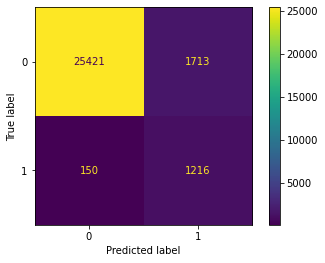

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

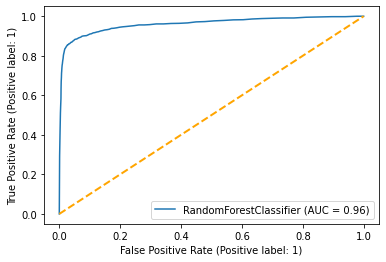

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,27.0,16.0,6.0,1.0,60.0,94.0,27.0,16.0,6.0,1.0,60.0,94.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
1,1243.0,252.0,151.0,1.0,66.0,5.0,252.0,151.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,37.0,17.0,3.0,2.0,18.0,93.0,37.0,17.0,3.0,2.0,18.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
2,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,2.0,18.0,152.0,1.0,840.0,93.0,2.0,18.0,152.0,1.0,840.0,93.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
3,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,38.0,19.0,3.0,1.0,16.0,92.0,38.0,19.0,3.0,1.0,16.0,92.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
4,1243.0,251.0,152.0,1.0,66.0,5.0,251.0,152.0,1.0,66.0,5.0,444.0,255.0,74.0,1.0,391.0,1.0,255.0,74.0,1.0,391.0,1.0,33.0,20.0,4.0,2.0,31.0,91.0,33.0,20.0,4.0,2.0,31.0,91.0,9998.0,10000.0,9996.0,2.0,1.0,2.0,1.0,1.0,9996.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94995,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,64.0,18.0,1.0,1.0,0.0,102.0,64.0,18.0,1.0,1.0,0.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
94996,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,40.0,19.0,2.0,1.0,8.0,102.0,40.0,19.0,2.0,1.0,8.0,102.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
94997,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,33.0,20.0,5.0,4.0,19.0,99.0,33.0,20.0,5.0,4.0,19.0,99.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
94998,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


In [47]:
y

0        0
1        0
2        0
3        0
4        0
        ..
94995    0
94996    0
94997    0
94998    0
94999    0
Name: is_fraud, Length: 95000, dtype: int64

In [48]:
len(df) / 2

47500.0

In [49]:
8353+8350

16703

In [50]:
len(df)

95000

In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 950 



In [52]:
len(df)

95000

In [53]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 950 

RangeIndex(start=0, stop=47500, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 1848, 1848
Counts of y = 1 and y = 0 in y_test: 427, 9073
0
Iteration difference 47500: ROC-AUC=0.9666
------------------------------------------------------------------------------------------------
RangeIndex(start=950, stop=48450, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 1841, 1841
Counts of y = 1 and y = 0 in y_test: 412, 9088
950
Iteration difference 47500: ROC-AUC=0.9627
------------------------------------------------------------------------------------------------
RangeIndex(start=1900, stop=49400, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 1833, 1833
Counts of y = 1 and y = 0 in y_test: 433, 9067
1900
Iteration difference 47500: ROC-AUC=0.9607
------------------------------------------------------------------------------------------------
RangeIndex(start=2850, stop=50350, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 1818, 1818

25650
Iteration difference 47500: ROC-AUC=0.9549
------------------------------------------------------------------------------------------------
RangeIndex(start=26600, stop=74100, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1811, 1811
Counts of y = 1 and y = 0 in y_test: 440, 9060
26600
Iteration difference 47500: ROC-AUC=0.9601
------------------------------------------------------------------------------------------------
RangeIndex(start=27550, stop=75050, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1796, 1796
Counts of y = 1 and y = 0 in y_test: 473, 9027
27550
Iteration difference 47500: ROC-AUC=0.9651
------------------------------------------------------------------------------------------------
RangeIndex(start=28500, stop=76000, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1796, 1796
Counts of y = 1 and y = 0 in y_test: 463, 9037
28500
Iteration difference 47500: ROC-AUC=0.9620
---------------------------------------------------

In [54]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
94998,893286638,bottom_689,top_729,0,H,10000,True,0.0,1412.0,275.0,231.0,1.0,64.0,4.0,275.0,231.0,1.0,64.0,4.0,486.0,260.0,64.0,1.0,429.0,1.0,260.0,64.0,1.0,429.0,1.0,12.0,21.0,25.0,6.0,253.0,94.0,12.0,21.0,24.0,6.0,254.0,94.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0
94999,893286638,bottom_748,top_729,0,H,10000,True,0.0,1412.0,276.0,230.0,1.0,64.0,4.0,276.0,230.0,1.0,64.0,4.0,486.0,261.0,63.0,1.0,429.0,1.0,261.0,63.0,1.0,429.0,1.0,33.0,22.0,6.0,6.0,19.0,89.0,33.0,22.0,6.0,6.0,19.0,89.0,9995.0,10000.0,9990.0,5.0,1.0,2.0,1.0,1.0,9990.0,5.0


In [55]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("MovieLens-5Perc-H10000-AUCInSlidingWindow.xlsx", index=False)

In [56]:
len(roc_auc_results)

50

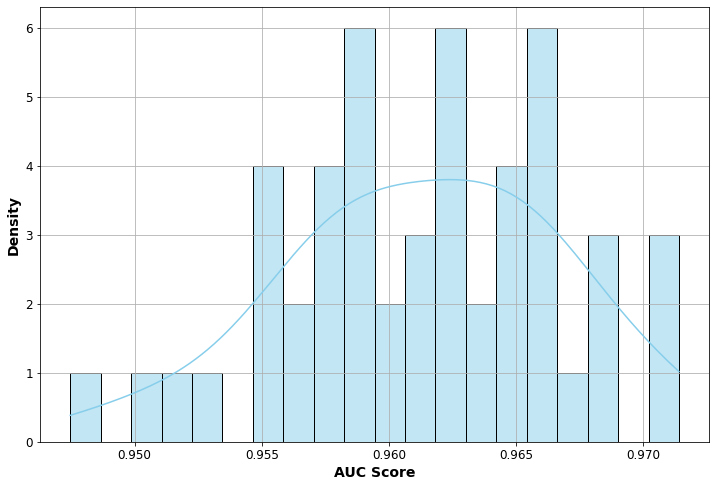

In [57]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()